In [1]:
from fastai.tabular.all import *


In [2]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare']) #log(1+input array to avoid the log0 error)
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_features(df)

In [6]:
splits = RandomSplitter(seed=42)(df)

In [17]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2.110213,NaN,1,False,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593,ABC,1,False,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2.188856,NaN,0,True,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.990834,ABC,1,False,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,2.202765,NaN,0,True,1,Mr
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,2.246893,NaN,0,True,1,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,3.967694,DE,0,True,1,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,3.094446,NaN,4,False,4,Master
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,2.495954,NaN,2,False,3,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,3.436268,NaN,1,False,2,Mrs


In [7]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

In [8]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])#for computer vision we use vision learner here we use tabular learner 

SuggestedLRs(slide=0.12022644281387329, valley=0.005248074419796467)

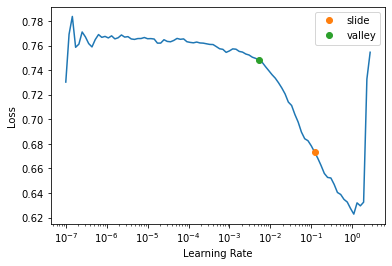

In [9]:
learn.lr_find(suggest_funcs=(slide, valley))#works with all fast.ai models

In [10]:
learn.fit(16, lr=0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.735465,0.703617,0.460674,00:00
1,0.709397,0.693339,0.488764,00:00
2,0.688649,0.668549,0.500000,00:00
3,0.669519,0.634485,0.730337,00:00
4,0.649473,0.598366,0.724719,00:00
5,0.631143,0.567206,0.769663,00:00
6,0.611715,0.542310,0.792135,00:00
7,0.594688,0.511529,0.814607,00:00
8,0.577900,0.480525,0.831461,00:00
9,0.559131,0.457617,0.837079,00:00


In [12]:
tst_df = pd.read_csv('test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

In [13]:
tst_dl = learn.dls.test_dl(tst_df)

In [14]:
preds,_ = learn.get_preds(dl=tst_dl)

In [15]:
tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub2.csv', index=False)

## ENSEMBLING

In [22]:
#CREATING MULTIPLE MODELS AND COMBINING THERE PREDICTIONS
def ensemble():
    learn = tabular_learner(dls,metrics=accuracy,layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16,lr=0.001)
    return learn.get_preds(dl=tst_dl)[0]

In [23]:
learns = [ensemble() for _ in range(5)]

In [24]:
ens_preds = torch.stack(learns).mean(0)

In [25]:
tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)